In [1]:
import numpy as np
import matplotlib.pyplot as plt

import utils.network as network_class
import utils.lstm_model as lstm_model_class
import utils.model_trainer as model_trainer_class
import utils.data_processer as data_processer_functions_lstm
import utils.transformer_model as transformer_model_class
import utils.data_processer_transformer as data_processer_functions_transformer

import torch
import torch.nn as nn

import pickle
from importlib import reload
from tqdm import trange
from pprint import pprint
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
print(torch.cuda.get_device_name(torch.cuda.current_device()))
print('CUDA Version', torch.version.cuda)
print('PyTorch Version', torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

NVIDIA GeForce RTX 2080 Ti
CUDA Version 11.3
PyTorch Version 1.12.1


# Define Network

In [3]:
num_nodes = 6
num_edges = 6

adjacency_nodexedge = np.zeros([num_nodes, num_edges]) # node x edge adjacency matrix of the network (with all tunnels)
adjacency_nodexedge = np.array([[-1, 0, 0, 0, 0, 0], # -1 => node is edge's source
                                [ 1,-1, 0,-1, 0, 0], # 1 => node is edge's destination
                                [ 0, 1,-1, 0, 0, 0],
                                [ 0, 0, 0, 1,-1, 0],
                                [ 0, 0, 1, 0, 1,-1],
                                [ 0, 0, 0, 0, 0, 1]])

num_tunnels = 2

is_edge_in_tunnel      = np.zeros([num_tunnels, num_edges, ])
external_arrival_rates = np.zeros([num_tunnels, num_nodes, ])
overlay_service_rates  = np.zeros([num_tunnels, num_edges, ])
underlay_service_rates = np.zeros([num_tunnels, num_edges, ])

# tunnel 0
is_edge_in_tunnel[0,:]      = np.array([1,1,1,0,0,1]) # 1 => edge is a part of the tunnel, 0 => otherwise
external_arrival_rates[0,:] = 2*np.array([0.9,0,0,0,0,0])
overlay_service_rates[0,:]  = 2*np.array([1,0,0,0,0,0])
underlay_service_rates[0,:] = 2*np.array([0,1,1,0,0,1])

# tunnel 1
is_edge_in_tunnel[1,:]      = np.array([1,0,0,1,1,1]) # 1 => edge is a part of the tunnel, 0 => otherwise
external_arrival_rates[1,:] = 2*np.array([0.9,0,0,0,0,0])
overlay_service_rates[1,:]  = 2*np.array([1,0,0,0,0,0])
underlay_service_rates[1,:] = 2*np.array([0,0,0,1,1,1])

In [4]:
reload(network_class)
my_network = network_class.Network(
    num_tunnels,
    num_nodes,
    num_edges,
    adjacency_nodexedge,
    is_edge_in_tunnel, 
    underlay_service_rates,
    external_arrival_rates)

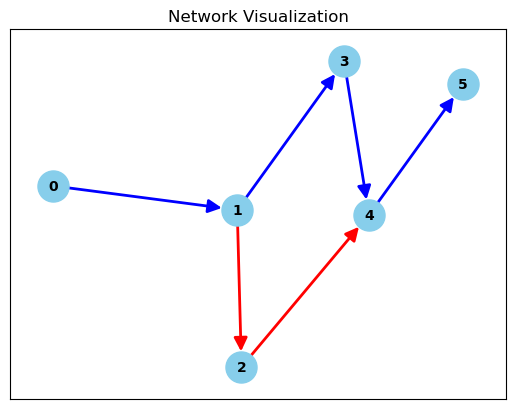

In [5]:
my_network.visualize(custom_seed = 1)

# Simulate Network

In [6]:
packets_in_flight_og, tunnel_backlogs_og, tunnel_injections_og, tunnel_exits_og = my_network.simulate(overlay_service_rates, total_time = 100000, custom_seed = 5)

In [7]:
T_start = 0
packets_in_flight, tunnel_backlogs, tunnel_injections, tunnel_exits = \
    packets_in_flight_og[T_start:,], tunnel_backlogs_og[T_start:,], tunnel_injections_og[T_start:,], tunnel_exits_og[T_start:,]

# Utility Functions

In [8]:
# used by transformer for masking future outputs
def generate_square_subsequent_mask(sz, device):
    mask = (torch.triu(torch.ones((sz, sz), device=device)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

def create_mask(src, tgt, device):
    src_seq_len = src.shape[1]
    tgt_seq_len = tgt.shape[1]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len, device)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=device).type(torch.bool)

    return src_mask, tgt_mask

In [9]:
def prepare_data_transformer(device, tunnel_backlogs, packets_in_flight, tunnel_injections, tunnel_exits, look_back, initial_fillers):
    # class to split data, scale data, and rescale data
    data_processer = data_processer_functions_transformer.DataProcessor()

    # create time series sequences with given look_back hyperparameter
    packets_in_flight_all = data_processer.create_sequences(torch.Tensor(packets_in_flight), look_back).to(device)
    tunnel_injections_all = data_processer.create_sequences(torch.Tensor(tunnel_injections), look_back).to(device)
    tunnel_exits_all = data_processer.create_sequences(torch.Tensor(tunnel_exits), look_back).to(device)

    # create transformer encoder inputs (source)
    src_all = data_processer.feature_transform(device, packets_in_flight_all)
    src_all = torch.concat((src_all, tunnel_injections_all), dim=-1)
    src_all = torch.concat((src_all, tunnel_exits_all), dim=-1)

    # create transformer decoder input/output (target)
    tgt_all = data_processer.create_sequences(torch.Tensor(tunnel_backlogs), look_back).to(device)

    # split into train and test
    src_train_unscaled, tgt_train_unscaled, \
        src_test_unscaled, tgt_test_unscaled = data_processer.split_train_test(src_all, tgt_all)

    # rescale to [0,1]
    src_train, tgt_train = data_processer.scale_train(src_train_unscaled, tgt_train_unscaled, is_x_sequenced = True)
    src_test, tgt_test = data_processer.scale_test(src_test_unscaled, tgt_test_unscaled)

    # decoder side of transformer will have inout and output
    tgt_train_input, tgt_train_output = data_processer.create_tgt_input_outputs(tgt_train, initial_fillers)
    tgt_test_input, tgt_test_output = data_processer.create_tgt_input_outputs(tgt_test, initial_fillers)

    return data_processer, src_train, tgt_train_input, tgt_train_output, src_test, tgt_test_input, tgt_test_output

In [10]:
def get_error_rates_transformer(transformer_predictor, src, tgt_output, data_processer, round_prediction = True):
    # get predictions
    transformer_predictor.eval()
    tgt_pred_output = transformer_predictor.evaluate(src)

    # rescale back to queue sizes
    _, tgt_pred_output_unscaled = data_processer.inverse_scale(src_scaled=0, tgt_scaled=tgt_pred_output)
    src_unscaled, tgt_output_unscaled = data_processer.inverse_scale(src_scaled=src, tgt_scaled=tgt_output)
    
    y_pred_unscaled = tgt_pred_output_unscaled.cpu().numpy()[:,-1,:]
    y_unscaled = tgt_output_unscaled.cpu().numpy()[:,-1,:]

    if(round_prediction): y_pred_unscaled = np.round(y_pred_unscaled)
    y_unscaled = np.round(y_unscaled)

    # calculate root mean squared error, and max absolute percentage error
    rmse = mean_squared_error(y_unscaled, y_pred_unscaled, squared = False)
    mape = mean_absolute_percentage_error(y_unscaled[y_unscaled>0], y_pred_unscaled[y_unscaled>0])*100
    error_rates = {'rmse': rmse, 'mape': mape}

    return error_rates, np.round(src_unscaled.cpu().numpy()), y_unscaled, y_pred_unscaled

In [11]:
def prepare_data_lstm(device, tunnel_backlogs, packets_in_flight, tunnel_injections, tunnel_exits, look_back):
    # class to split data, scale data, and rescale data
    data_processer = data_processer_functions_lstm.DataProcessor()

    # create time series sequences with given look_back hyperparameter
    packets_in_flight_all = data_processer.create_sequences(torch.Tensor(packets_in_flight), look_back).to(device)
    tunnel_injections_all = data_processer.create_sequences(torch.Tensor(tunnel_injections), look_back).to(device)
    tunnel_exits_all = data_processer.create_sequences(torch.Tensor(tunnel_exits), look_back).to(device)

    # create x values from packets in flight, tunnel injections, and exits
    x_all = data_processer.feature_transform(device, packets_in_flight_all)
    x_all = torch.concat((x_all, tunnel_injections_all), dim=-1)
    x_all = torch.concat((x_all, tunnel_exits_all), dim=-1)
    
    # create y values from queue backlogs
    y_all = torch.Tensor(tunnel_backlogs).to(device)

    # split into train and test
    x_train_unscaled, y_train_unscaled, x_test_unscaled, y_test_unscaled = data_processer.split_train_test(x_all, y_all)

    # rescale to [0,1]
    x_train, y_train = data_processer.scale_train(x_train_unscaled, y_train_unscaled, is_x_sequenced = True)
    x_test, y_test = data_processer.scale_test(x_test_unscaled, y_test_unscaled)

    return data_processer, x_train, y_train, x_test, y_test

In [12]:
def get_error_rates_lstm(lstm_predictor, x, y, data_processer, round_prediction = True):
    # get predictions
    lstm_predictor.eval()
    y_pred = lstm_predictor.evaluate(x)

    # rescale back to queue sizes
    _, y_pred_unscaled = data_processer.inverse_scale(x_scaled=0, y_scaled=y_pred)
    x_unscaled, y_unscaled = data_processer.inverse_scale(x_scaled=x, y_scaled=y)

    y_pred_unscaled = y_pred_unscaled.cpu().numpy()
    y_unscaled = y_unscaled.cpu().numpy()

    if(round_prediction): y_pred_unscaled = np.round(y_pred_unscaled)
    y_unscaled = np.round(y_unscaled)

    # calculate root mean squared error, and max absolute percentage error
    rmse = mean_squared_error(y_unscaled, y_pred_unscaled, squared = False) 
    mape = mean_absolute_percentage_error(y_unscaled[y_unscaled>0], y_pred_unscaled[y_unscaled>0])*100 
    error_rates = {'rmse': rmse, 'mape': mape}

    return error_rates, np.round(x_unscaled.cpu().numpy()), y_unscaled, y_pred_unscaled

In [13]:
def get_error_rates_mars_linreg(x, y, y_pred, round_prediction=True):
    if(round_prediction): y_pred = np.round(y_pred)
    y = np.round(y)

    # calculate root mean squared error, and max absolute percentage error
    rmse = mean_squared_error(y, y_pred, squared = False) 
    mape = mean_absolute_percentage_error(y[y>0], y_pred[y>0])*100 
    error_rates = {'rmse': rmse, 'mape': mape}

    return error_rates, np.round(x), y, y_pred

# Plot Functions

In [82]:
def running_average(arr, window_size = 1000):
    arr = np.concatenate((np.zeros([window_size,]), arr), axis=0)
    cumsum = np.cumsum(arr)
    running_avg = (cumsum[window_size:] - cumsum[:-window_size]) / window_size
    return running_avg

def plot_queue_evolution(y, y_pred_all_models, model_labels, tunnel_ii, T_to_plot = 1000, window_size = 50):
    plt.plot(running_average(y[:T_to_plot,tunnel_ii], window_size), label = 'True backlog', linewidth=2)
    plot_styles = [ '-.', '--', ':', '-']
    alpha_vals = [1,0.9,0.8,0.7]
    for ii in range(len(model_labels)):
        plt.plot(running_average(y_pred_all_models[ii][:T_to_plot,tunnel_ii], window_size), plot_styles[ii], label = model_labels[ii] + ' pred backlog', alpha=alpha_vals[ii], linewidth=2)
    plt.xlabel('Time')
    plt.ylabel('Backlog evolution tunnel '+str(tunnel_ii))
    plt.legend()
    plt.show()

In [36]:
def plot_error_scatter_plot(x_test_all_models, y_test_all_models, y_pred_all_models, model_labels, tunnel_ii):
    num_models = len(model_labels)
    fig, axs = plt.subplots(1, num_models, figsize=(16, 4)) 
    # fig, axs = plt.subplots(2, 2, figsize=(10, 8)) 

    for model_ii in range(num_models):
        x_in = x_test_all_models[model_ii]
        y_abs_error = np.abs(y_test_all_models[model_ii][:,tunnel_ii] - y_pred_all_models[model_ii][:,tunnel_ii])
        scatter_ii = axs[model_ii].scatter(x_in[:, 1], x_in[:, 0], c = y_abs_error, cmap='viridis', s=5, alpha=0.7)
        axs[model_ii].set_xlabel('Packets in flight tunnel 1')
        axs[model_ii].set_ylabel('Packets in flight tunnel 0')
        colorbar_ii = plt.colorbar(scatter_ii, ax=axs[model_ii])
        axs[model_ii].set_title(model_labels[model_ii] + ' | absolute error | tunnel ' + str(tunnel_ii))

    plt.tight_layout()
    plt.show()

In [50]:
def plot_predicted_scatter_plot(x_test_all_models, y_test_all_models, y_pred_all_models, model_labels, tunnel_ii):
    num_models = len(model_labels)
    fig, axs = plt.subplots(1, num_models+1, figsize=(20, 4)) 

    x_in = x_test_all_models[0]
    y_true = y_test_all_models[0]
    scatter_0 = axs[0].scatter(x_in[:, 1], x_in[:, 0], c = y_true[:,tunnel_ii], cmap='viridis', s=5, alpha=0.7)
    axs[0].set_xlabel('Packets in flight tunnel 1')
    axs[0].set_ylabel('Packets in flight tunnel 0')
    plt.colorbar(scatter_0, ax=axs[0])
    axs[0].set_title('True backlogs | tunnel ' + str(tunnel_ii))

    for model_ii in np.arange(1,num_models+1):
        x_in = x_test_all_models[model_ii-1]
        y_pred = y_pred_all_models[model_ii-1]
        scatter_ii = axs[model_ii].scatter(x_in[:, 1], x_in[:, 0], c = y_pred[:,tunnel_ii], cmap='viridis', s=5, alpha=0.7)
        axs[model_ii].set_xlabel('Packets in flight tunnel 1')
        axs[model_ii].set_ylabel('Packets in flight tunnel 0')
        plt.colorbar(scatter_ii, ax=axs[model_ii])
        axs[model_ii].set_title(model_labels[model_ii-1] + ' | pred backlogs | tunnel ' + str(tunnel_ii))

    plt.tight_layout()
    plt.show()

In [38]:
def plot_tunnel_scatter_plot(x_test_all_models, y_test_all_models, y_pred_all_models, model_labels, tunnel_ii): 
    num_models = len(model_labels)
    fig, axs = plt.subplots(1, num_models, figsize=(16, 4)) 
    # fig, axs = plt.subplots(2, 2, figsize=(10, 8)) 

    for model_ii in range(num_models):
        x = x_test_all_models[model_ii]
        y = y_test_all_models[model_ii]
        y_pred = y_pred_all_models[model_ii]
        
        axs[model_ii].scatter(x[:,tunnel_ii], y[:,tunnel_ii], label='True backlog', cmap='viridis', s=6, alpha=0.8)
        axs[model_ii].scatter(x[:,tunnel_ii], y_pred[:,tunnel_ii], label='Predicted backlog', cmap='viridis', s=6, alpha=0.3)
        axs[model_ii].set_xlabel('Packets in flight tunnel '+str(tunnel_ii))
        axs[model_ii].set_ylabel('Queue backlogs tunnel '+str(tunnel_ii))
        axs[model_ii].legend()
        axs[model_ii].set_title(model_labels[model_ii] + ' | backlog vs PIF | tunnel ' + str(tunnel_ii))

    plt.tight_layout()
    plt.show()

# Load MARS and Linear Regression Models

In [18]:
file_name = 'final_network2'
with open(file_name + '_saved_mars_linreg_model.pkl', 'rb') as file: loaded_model = pickle.load(file)

c:\Users\Windows\Anaconda3\envs\env_chadaga\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LinearRegression from version 1.3.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [19]:
# get saved data for MARS and Regression Models
x_mars, y_mars, y_pred_mars = loaded_model['x_test'], loaded_model['y_test'], loaded_model['y_MARS_pred']
x_linreg, y_linreg, y_pred_linreg = loaded_model['x_test'], loaded_model['y_test'], loaded_model['y_lin_pred']

In [20]:
# get test performance metrics
test_error_rates_mars, x_test_mars, y_test_mars, y_pred_test_mars = get_error_rates_mars_linreg(x_mars, y_mars, y_pred_mars)
test_error_rates_linreg, x_test_linreg, y_test_linreg, y_pred_test_linreg = get_error_rates_mars_linreg(x_linreg, y_linreg, y_pred_linreg)

# Load LSTM Model

In [21]:
file_name = 'final_network2'
with open(file_name + '_saved_lstm_model.pkl', 'rb') as file: loaded_model = pickle.load(file)

In [22]:
# get saved best model performance
look_back = loaded_model['look_back']
lstm_predictor = loaded_model['model']

# prepare data
data_processer, _, _, x_test, y_test = prepare_data_lstm(device, tunnel_backlogs, packets_in_flight, tunnel_injections, tunnel_exits, look_back)

In [23]:
# get test performance metrics
test_error_rates_lstm, x_test_lstm, y_test_lstm, y_pred_test_lstm = get_error_rates_lstm(lstm_predictor, x_test, y_test, data_processer)

c:\Users\Windows\Anaconda3\envs\env_chadaga\lib\site-packages\torch\nn\modules\rnn.py:769: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


# Load Transformer Model

In [24]:
file_name = 'final_network2'
with open(file_name + '_saved_transformer_model.pkl', 'rb') as file: loaded_model = pickle.load(file)

In [25]:
# get saved best performing model
look_back = loaded_model['look_back']
transformer_predictor = loaded_model['model']
initial_fillers = loaded_model['initial_fillers']

# prepare data
data_processer, _, _, _, src_test, _, tgt_test_output = prepare_data_transformer(device, tunnel_backlogs, packets_in_flight, tunnel_injections, tunnel_exits, look_back, initial_fillers)

In [26]:
test_error_rates_transformer, x_test_transformer, y_test_transformer, y_pred_test_transformer = get_error_rates_transformer(transformer_predictor, src_test, tgt_test_output, data_processer)

# Verify Data are Matched

In [27]:
print(np.sum(x_test_mars - x_test_lstm[:,-1,:2]))
print(np.sum(x_test_linreg - x_test_lstm[:,-1,:2]))
print(np.sum(x_test_transformer[:,-1,:2] - x_test_lstm[:,-1,:2]))

print(np.sum(y_test_mars - y_test_lstm))
print(np.sum(y_test_linreg - y_test_lstm))
print(np.sum(y_test_transformer - y_test_lstm))

print(np.sum(y_pred_test_mars - y_pred_test_lstm))
print(np.sum(y_pred_test_linreg - y_pred_test_lstm))
print(np.sum(y_pred_test_transformer - y_pred_test_lstm))

0.0
0.0
0.0
0.0
0.0
0.0
-260.0
-217.0
11375.0


# Visualize Comparison

In [28]:
print('Final test rounded performance:')
print('Transformer', test_error_rates_transformer)
print('MARS       ', test_error_rates_mars)
print('Regression ', test_error_rates_linreg)
print('LSTM       ', test_error_rates_lstm)

Final test rounded performance:
Transformer {'rmse': 7.642268, 'mape': 10.27197614312172}
MARS        {'rmse': 7.499201927261282, 'mape': 10.14994694626004}
Regression  {'rmse': 7.498609835753536, 'mape': 10.149322354898313}
LSTM        {'rmse': 7.4545436, 'mape': 10.105830430984497}


In [29]:
model_labels = ['LSTM', 'Regression', 'MARS', 'Transformer', ]
x_test_all_models = [x_test_lstm[:,-1,:2], x_test_linreg, x_test_mars, x_test_transformer[:,-1,:2]]
y_test_all_models = [y_test_lstm, y_test_linreg, y_test_mars, y_test_transformer]
y_pred_all_models = [y_pred_test_lstm, y_pred_test_linreg, y_pred_test_mars, y_pred_test_transformer]

## Tunnel 0 Performance

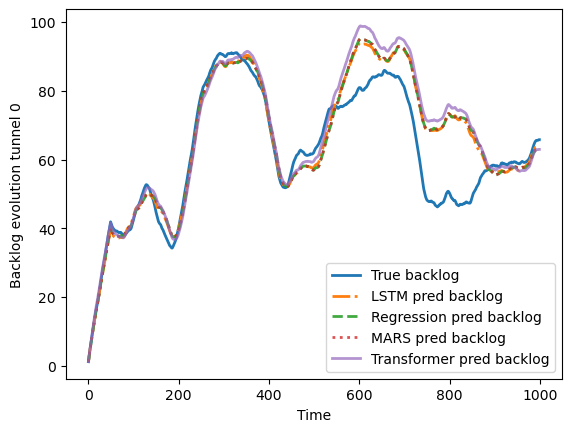

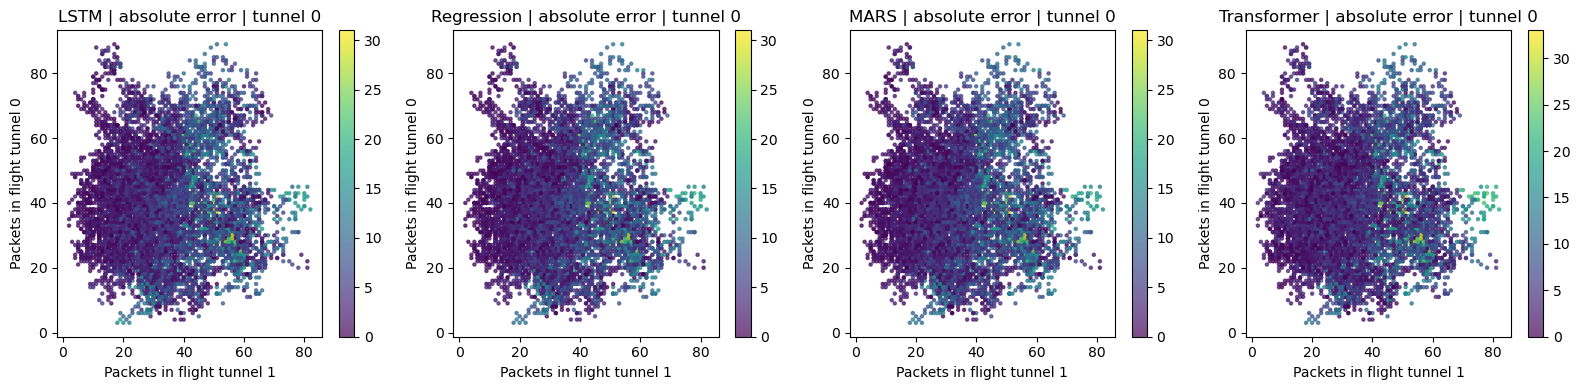

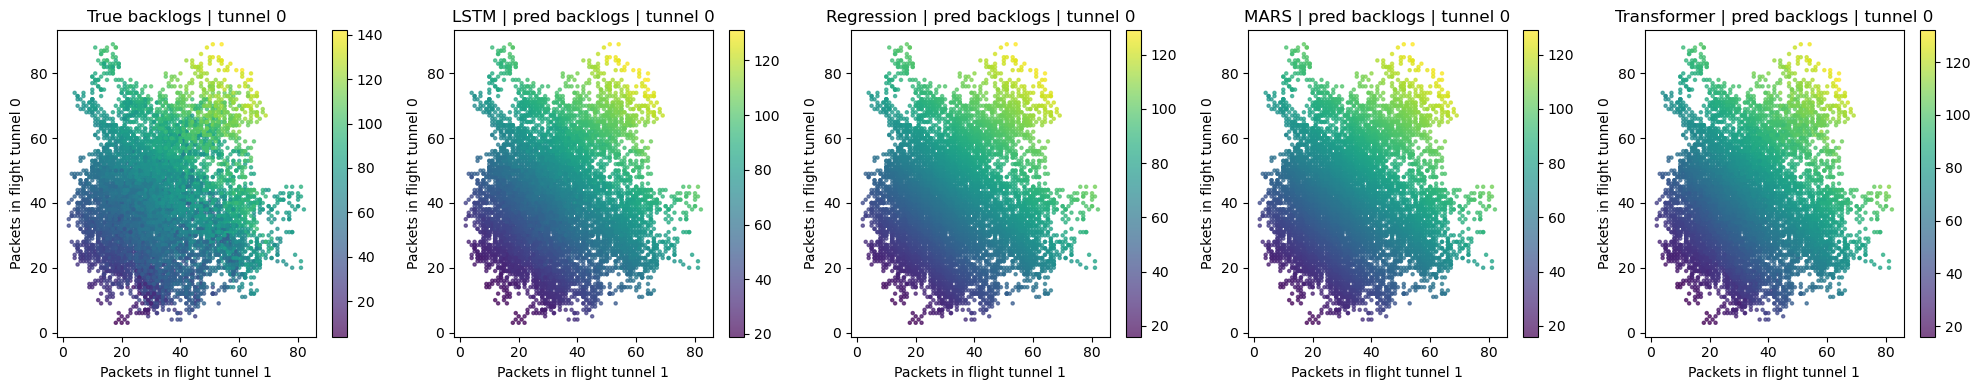

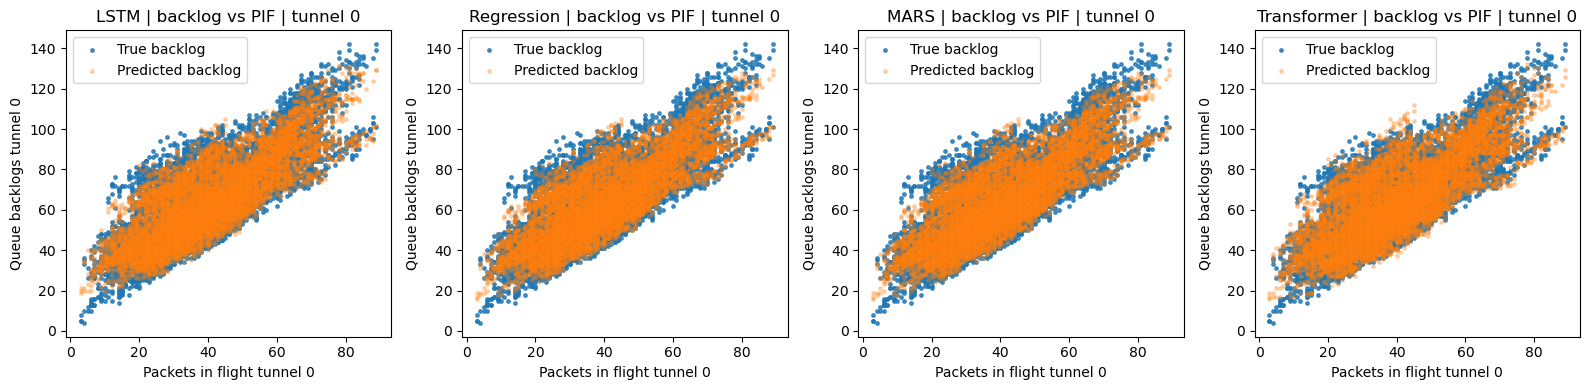

In [83]:
tunnel_ii = 0
plot_queue_evolution(y_test_mars, y_pred_all_models, model_labels, tunnel_ii)
plot_error_scatter_plot(x_test_all_models, y_test_all_models, y_pred_all_models, model_labels, tunnel_ii)
plot_predicted_scatter_plot(x_test_all_models, y_test_all_models, y_pred_all_models, model_labels, tunnel_ii)
plot_tunnel_scatter_plot(x_test_all_models, y_test_all_models, y_pred_all_models, model_labels, tunnel_ii)

## Tunnel 1 Performance

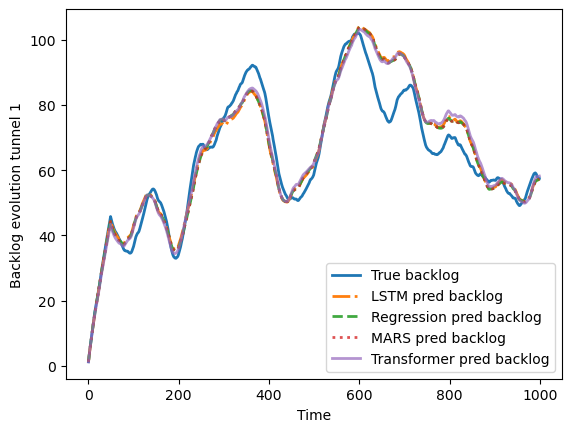

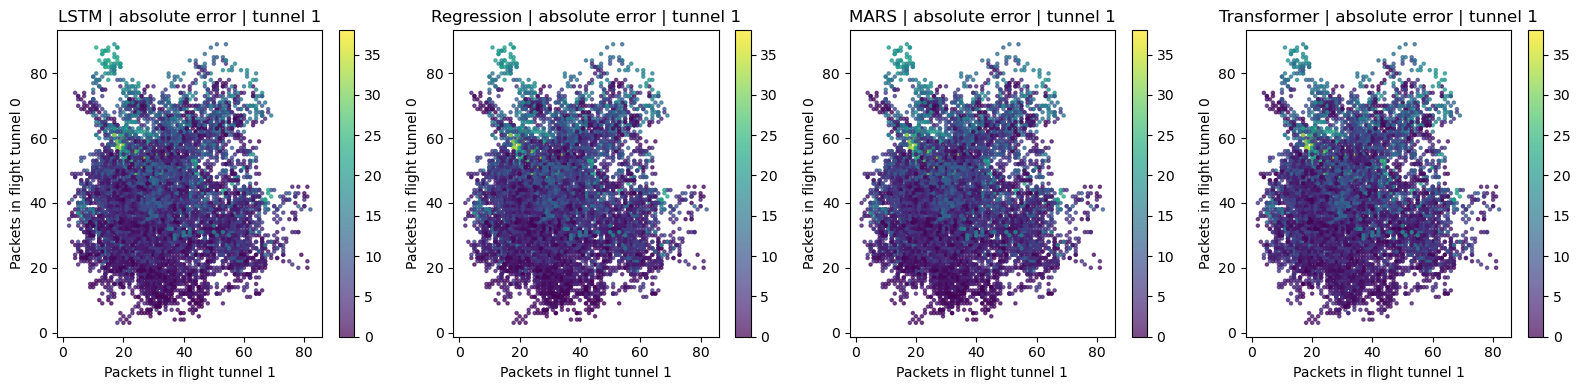

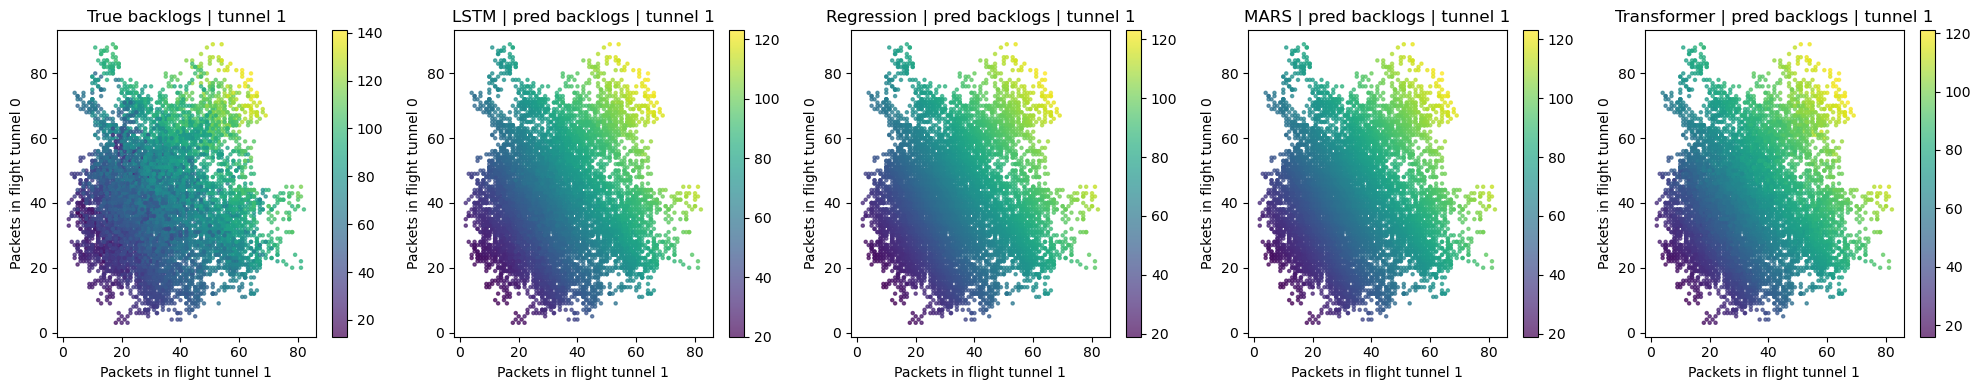

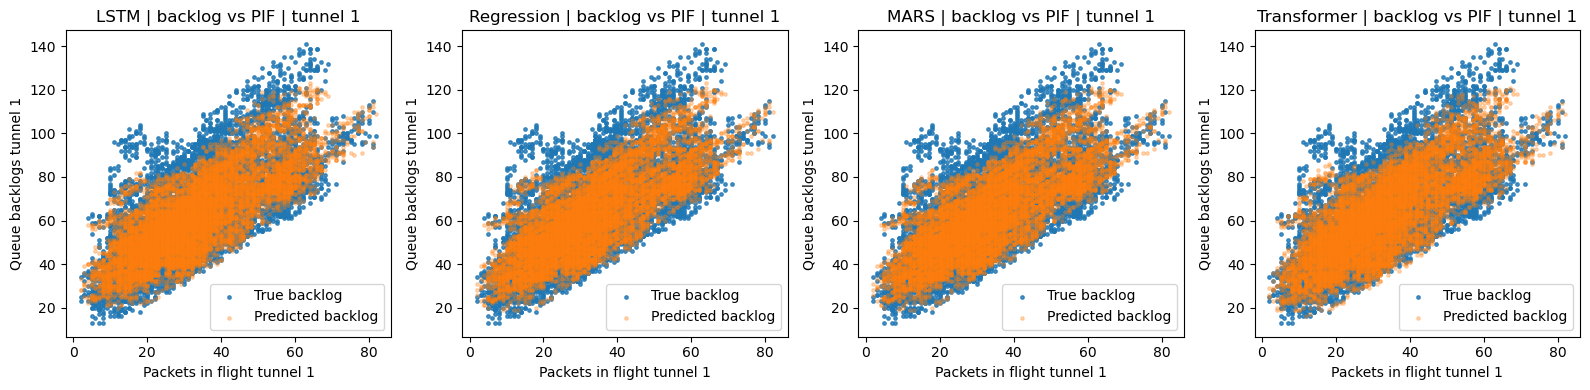

In [84]:
tunnel_ii = 1
plot_queue_evolution(y_test_mars, y_pred_all_models, model_labels, tunnel_ii)
plot_error_scatter_plot(x_test_all_models, y_test_all_models, y_pred_all_models, model_labels, tunnel_ii)
plot_predicted_scatter_plot(x_test_all_models, y_test_all_models, y_pred_all_models, model_labels, tunnel_ii)
plot_tunnel_scatter_plot(x_test_all_models, y_test_all_models, y_pred_all_models, model_labels, tunnel_ii)